In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
39057,NaN,NaN,International,2020-08-21,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39058,NaN,NaN,International,2020-08-22,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39059,NaN,NaN,International,2020-08-23,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


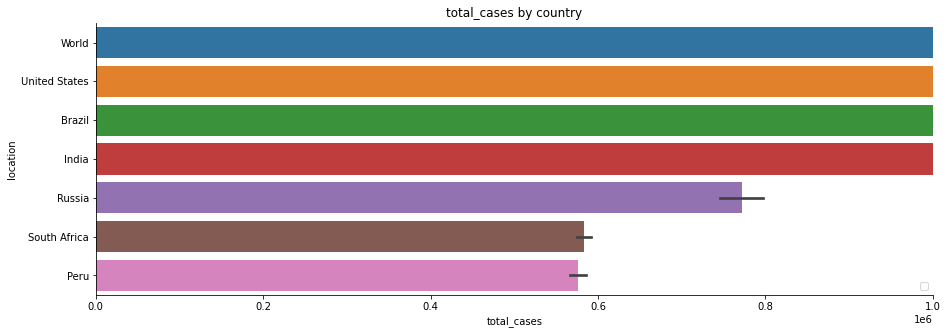

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


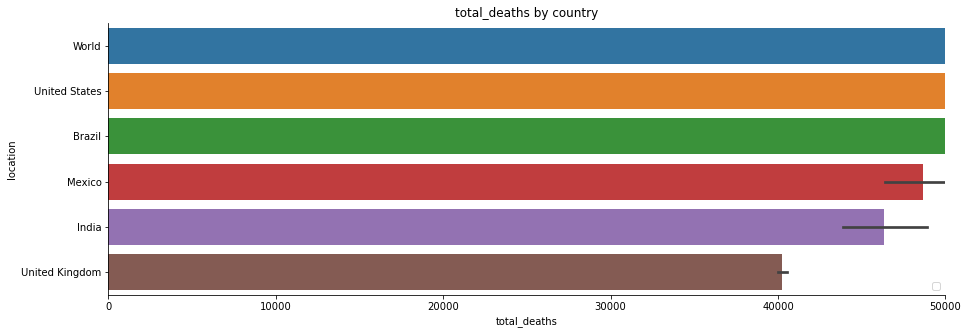

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


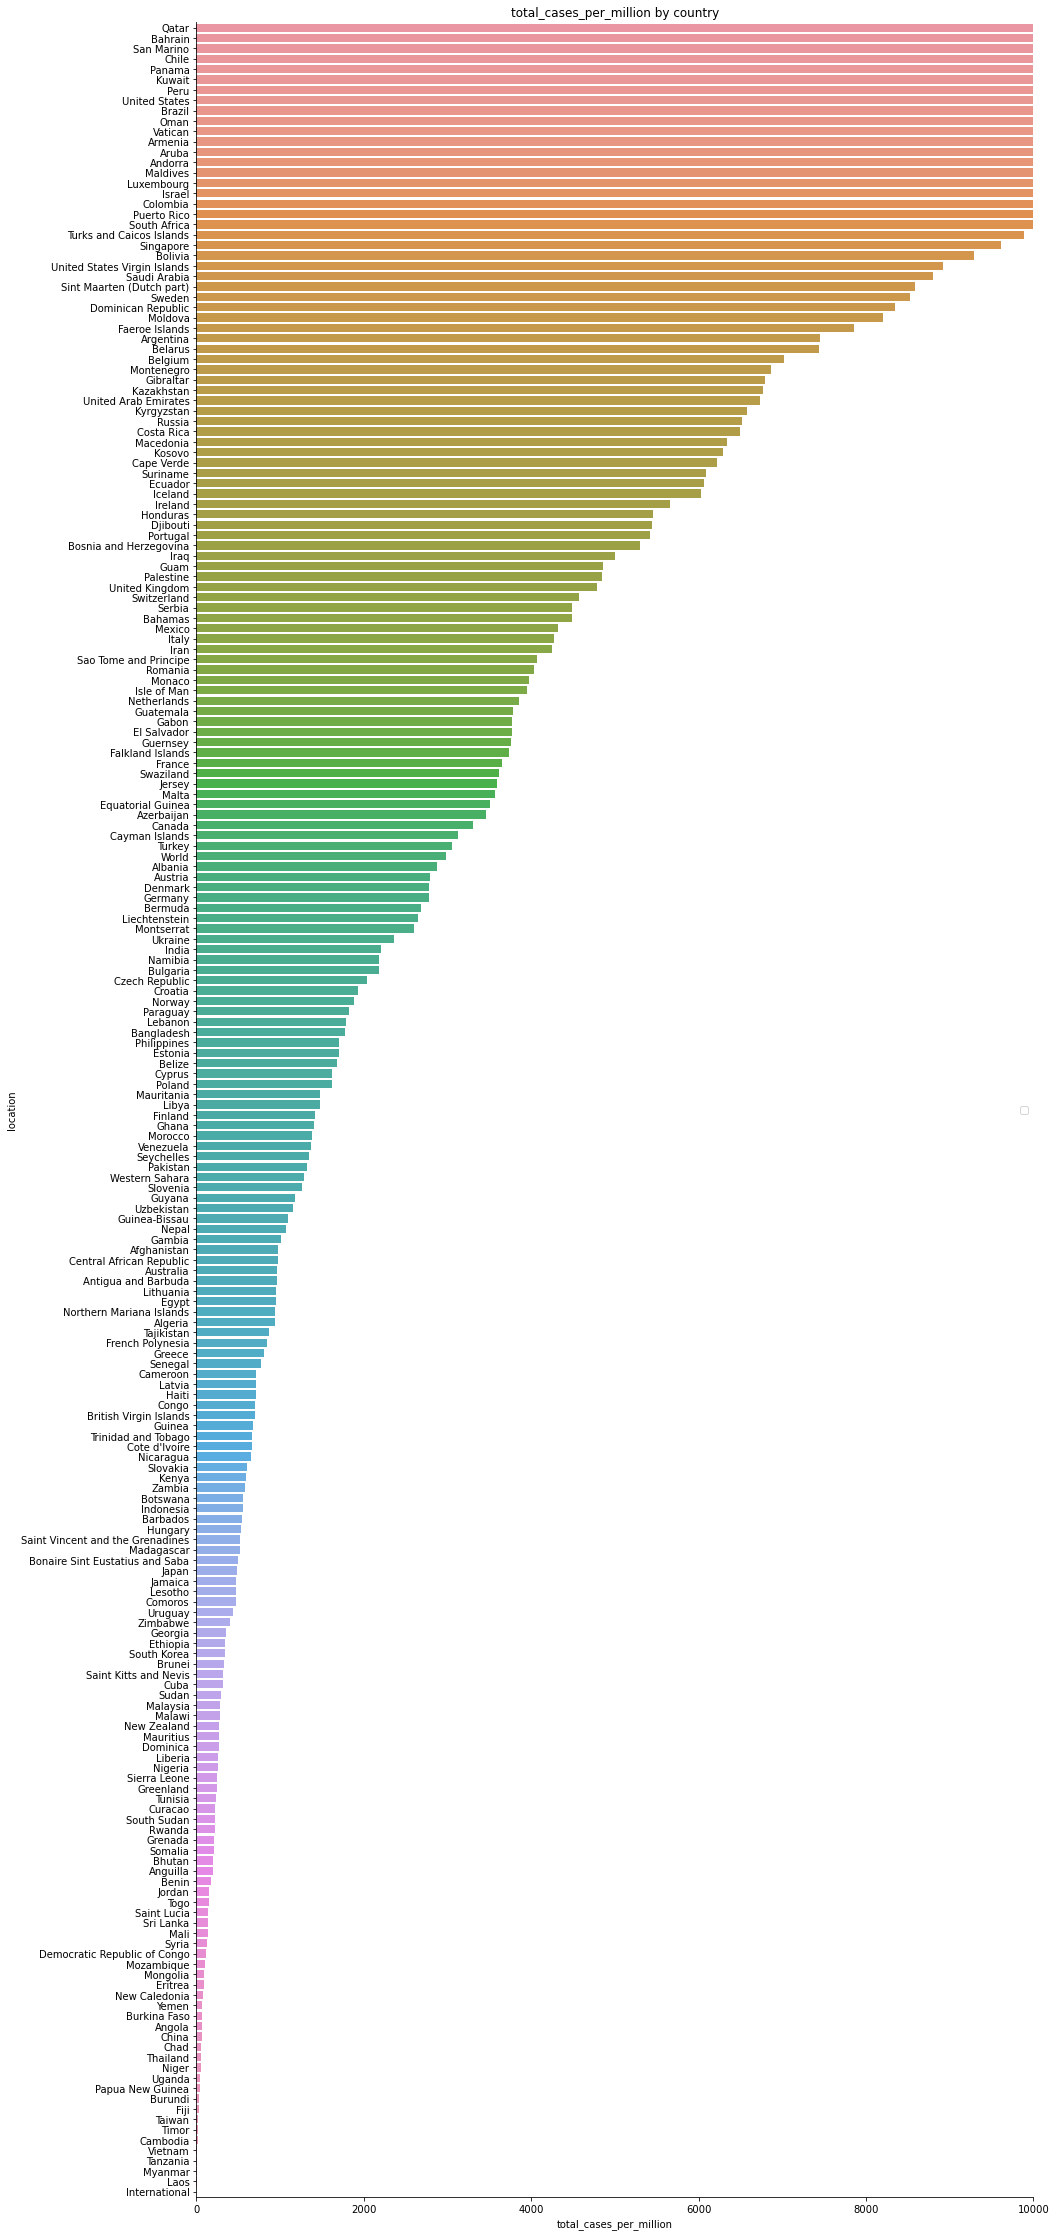

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


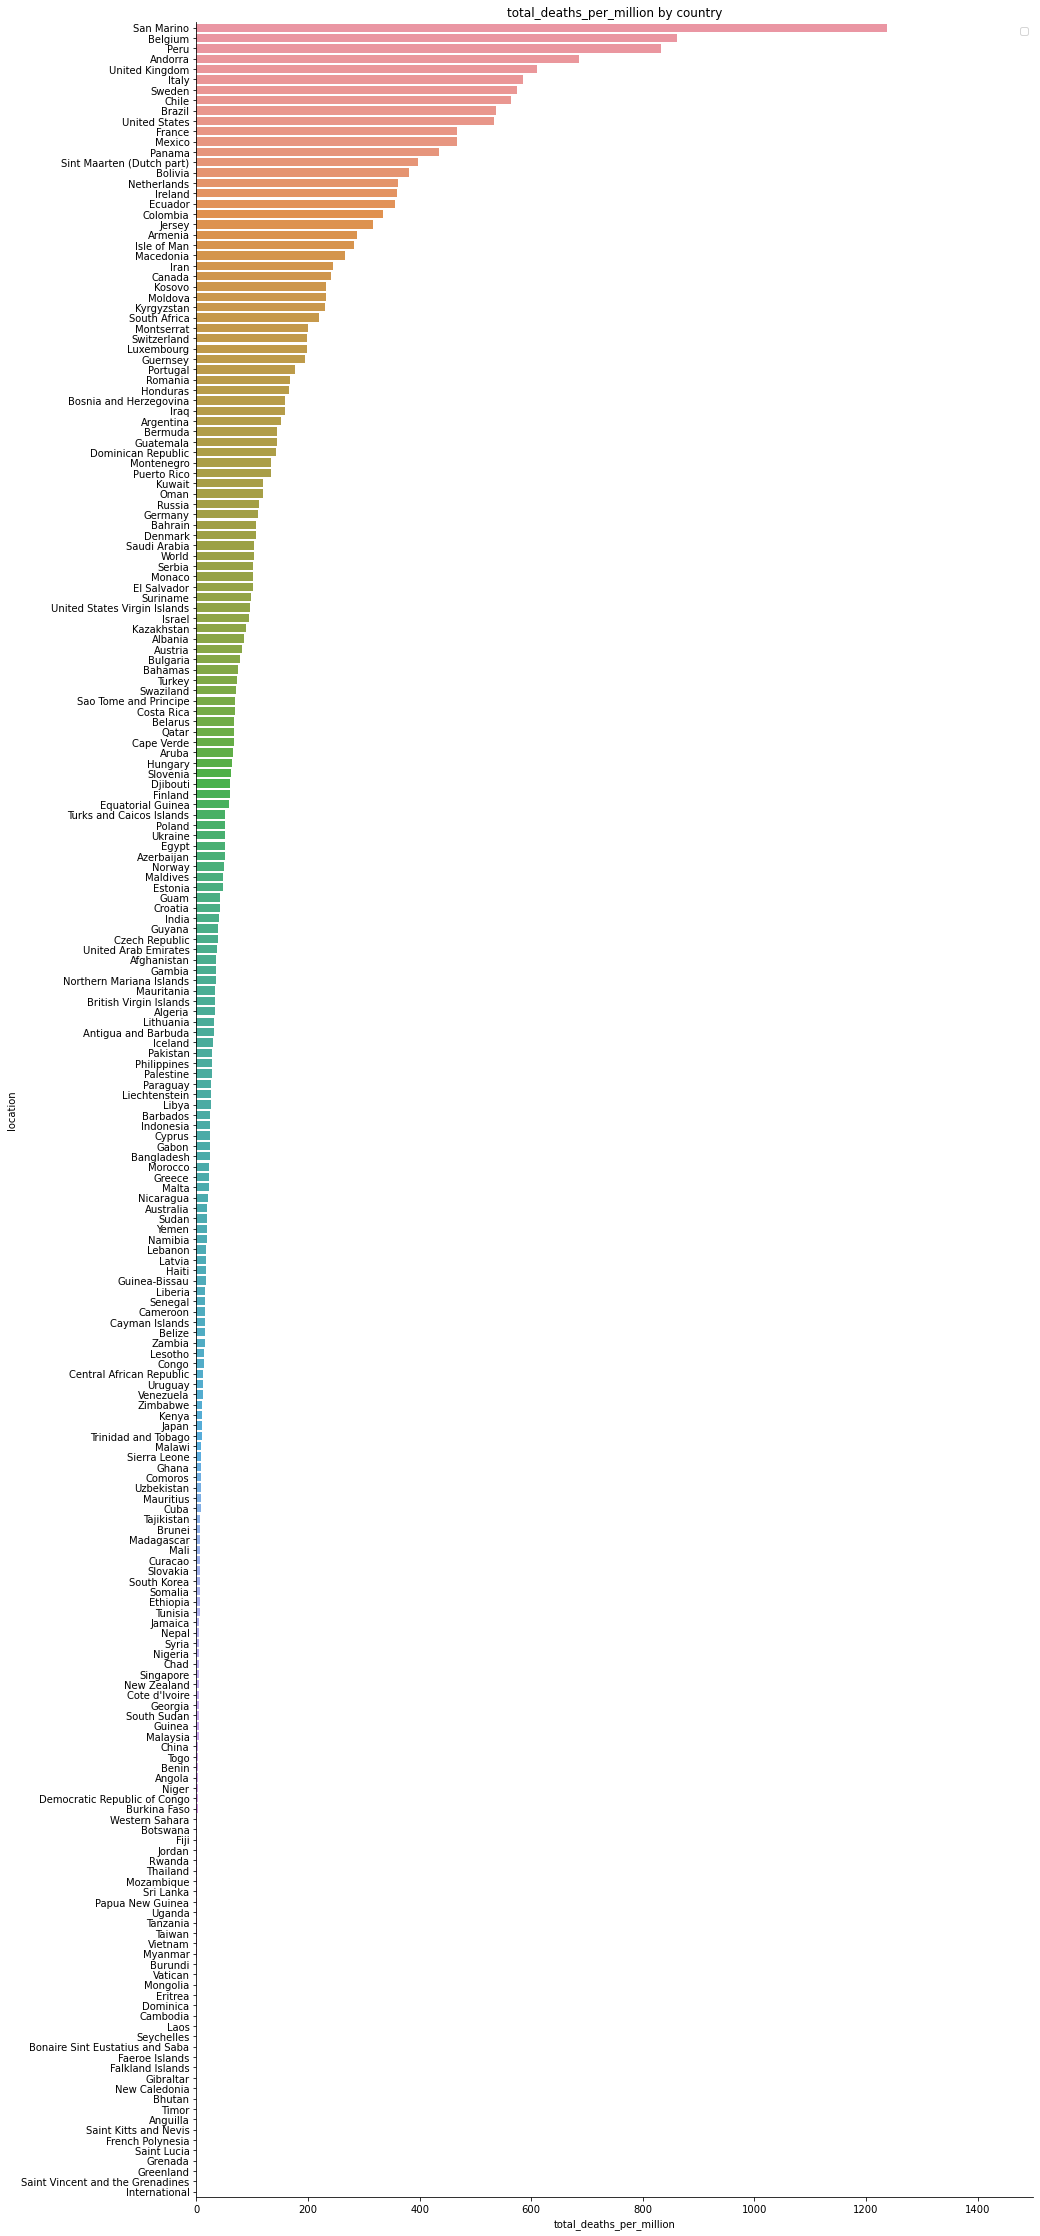

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

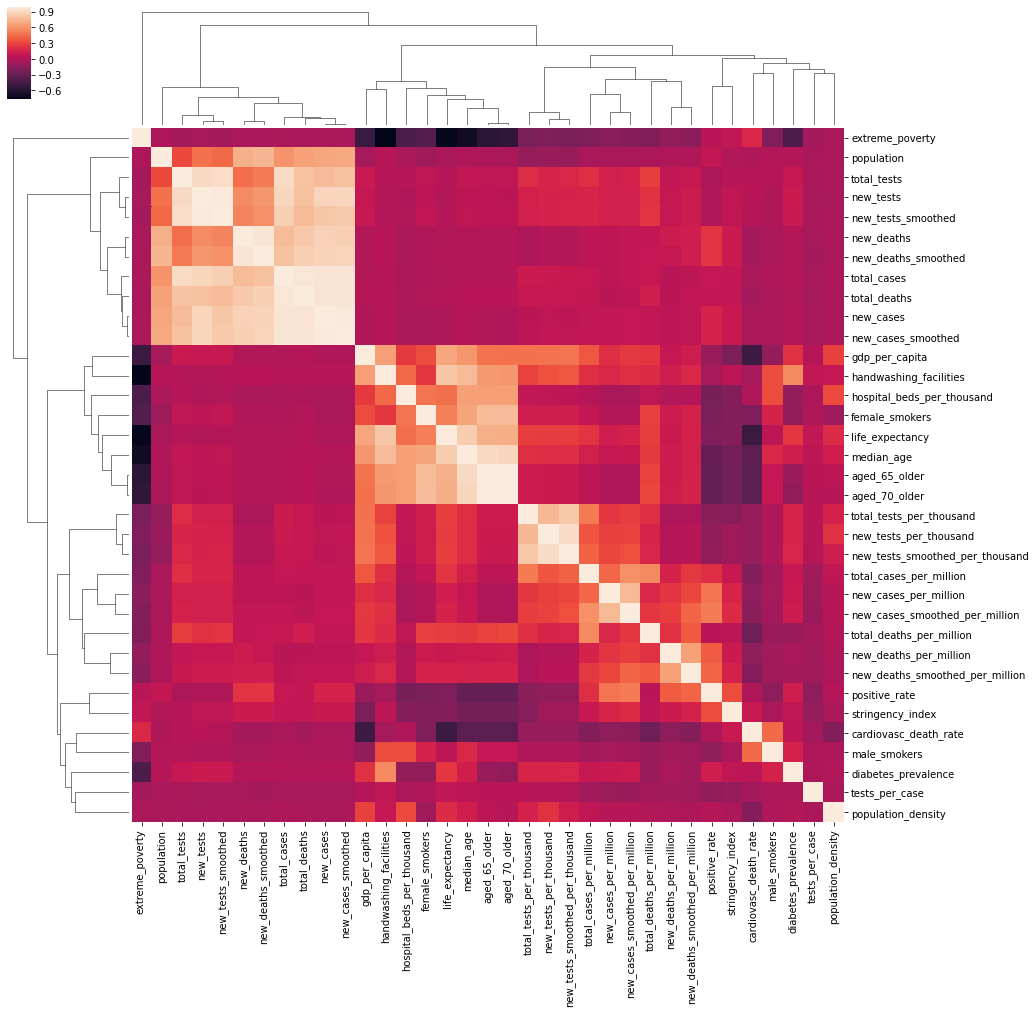

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995603033292788 (+/- 0.0002657002676089392)
Coef :  [1.04051908e+00 8.64722004e-05 9.12700683e-05]
3 Last_days :  [[22714274 22977973 23243621]]
Today :  23243621
Prediction + :  467867
Tomorow :  23711488
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996192219463859 (+/- 2.9673002901565376e-05)
Coef :  [-0.02807018  0.50193882  0.53632867]
3 Last_days :  [[794139 800223 805740]]
Today :  805740
Prediction + :  8072
Tomorow :  813812
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9884915752129483 (+/- 0.00831054221916197)
Coef :  [-0.67432743  0.72958393  0.94613098]
3 Last_days :  [[229814 234400 238002]]
Today :  238002
Prediction + :  3501
Tomorow :  241503
                                     
--------- Total Death -----------------
                                     
R^2: 0.37682911670414637 (+/- 0.8686495070880162)
Coef :  [-0.75415325  0.78854604  0.96469826]
3 Last_days :  [[30480 30503 30512]]
Today :  30512
Prediction + :  40
Tomorow :  30552
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.867538138638792 (+/- 0.0946792657841924)
Coef :  [-0.32287465 -0.02303183  1.34017786]
3 Last_days :  [[89567 89616 89654]]
Today :  89654
Prediction + :  43
Tomorow :  89697
                                     
--------- Total Death -----------------
                                     
R^2: -559.7180380957057 (+/- 792.7703053962794)
Coef :  [-0.07675466  0.01242612  1.05632002]
3 Last_days :  [[4709 4711 4711]]
Today :  4711
Prediction + :  6
Tomorow :  4717
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.3489594261141537 (+/- 0.919320384384255)
Coef :  [-0.83361587  0.9030018   0.92984929]
3 Last_days :  [[256118 257065 258136]]
Today :  258136
Prediction + :  892
Tomorow :  259028
                                     
--------- Total Death -----------------
                                     
R^2: 0.9105594704697543 (+/- 0.09984260626848332)
Coef :  [-0.83276381  0.90164618  0.93028816]
3 Last_days :  [[35418 35427 35430]]
Today :  35430
Prediction + :  29
Tomorow :  35459
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7732361820841217 (+/- 0.3109341943222983)
Coef :  [-0.69273464  0.58239447  1.11071404]
3 Last_days :  [[377906 386054 386054]]
Today :  386054
Prediction + :  6081
Tomorow :  392135
                                     
--------- Total Death -----------------
                                     
R^2: 0.21724183038601538 (+/- 0.9317455519391039)
Coef :  [-0.72023461  0.61470652  1.10452455]
3 Last_days :  [[28813 28838 28838]]
Today :  28838
Prediction + :  26
Tomorow :  28864
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.992571170867365 (+/- 0.010180596143813938)
Coef :  [0.08212138 0.46425348 0.47194158]
3 Last_days :  [[5573847 5623727 5668105]]
Today :  5668105
Prediction + :  87400
Tomorow :  5755505
                                     
--------- Total Death -----------------
                                     
R^2: 0.4626056504700439 (+/- 0.758502334799873)
Coef :  [-0.59556842  0.7550108   0.84298057]
3 Last_days :  [[174255 175406 176362]]
Today :  176362
Prediction + :  1235
Tomorow :  177597
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9888590270582679 (+/- 0.01478595784147725)
Coef :  [-0.76914506  0.87117283  0.89807288]
3 Last_days :  [[322280 323313 324601]]
Today :  324601
Prediction + :  1149
Tomorow :  325750
                                     
--------- Total Death -----------------
                                     
R^2: 0.41556580815151767 (+/- 0.7970167585180029)
Coef :  [-0.77548168  0.83253492  0.94242573]
3 Last_days :  [[41403 41405 41423]]
Today :  41423
Prediction + :  39
Tomorow :  41462
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9859873433047811 (+/- 0.016940362609257433)
Coef :  [-0.80970222  0.86628523  0.94313259]
3 Last_days :  [[228621 232082 232864]]
Today :  232864
Prediction + :  2983
Tomorow :  235847
                                     
--------- Total Death -----------------
                                     
R^2: 0.4179177876728903 (+/- 0.8094384928014158)
Coef :  [-0.79503359  0.84220738  0.95221156]
3 Last_days :  [[9253 9267 9269]]
Today :  9269
Prediction + :  18
Tomorow :  9287
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.933645891648118 (+/- 2.7337769636714517)
Coef :  [0.20055721 0.40841267 0.40372016]
3 Last_days :  [[352558 354764 356792]]
Today :  356792
Prediction + :  4109
Tomorow :  360901
                                     
--------- Total Death -----------------
                                     
R^2: 0.8993128930722487 (+/- 0.14202925848197534)
Coef :  [0.00062562 0.51129746 0.50181455]
3 Last_days :  [[20264 20376 20502]]
Today :  20502
Prediction + :  262
Tomorow :  20764
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9984840018053832 (+/- 0.0018852972888642992)
Coef :  [-0.75178802  0.85513865  0.89386567]
3 Last_days :  [[254520 255723 257032]]
Today :  257032
Prediction + :  1045
Tomorow :  258077
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993862984729737 (+/- 0.0005638869829557896)
Coef :  [-0.81828756  0.89825078  0.91703976]
3 Last_days :  [[6058 6080 6102]]
Today :  6102
Prediction + :  19
Tomorow :  6121
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.45746209548655764 (+/- 0.7635493880158768)
Coef :  [-0.16264334  0.48998318  0.6903842 ]
3 Last_days :  [[3501975 3532330 3582362]]
Today :  3582362
Prediction + :  57347
Tomorow :  3639709
                                     
--------- Total Death -----------------
                                     
R^2: 0.49730588072460713 (+/- 0.7032295994819144)
Coef :  [-0.15407304  0.53506283  0.63243834]
3 Last_days :  [[112304 113358 114250]]
Today :  114250
Prediction + :  1584
Tomorow :  115834
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(23243621, 805740, 23711488, 813812),
 (238002, 30512, 241503, 30552),
 (258136, 35430, 259028, 35459),
 (386054, 28838, 392135, 28864),
 (5668105, 176362, 5755505, 177597),
 (89654, 4711, 89697, 4717),
 (324601, 41423, 325750, 41462),
 (232864, 9269, 235847, 9287),
 (356792, 20502, 360901, 20764),
 (257032, 6102, 258077, 6121),
 (3582362, 114250, 3639709, 115834)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-23,France,241503.0,0.0,30552.0,0.0,0.0,0.0
0,2020-08-23,China,89697.0,0.0,4717.0,0.0,0.0,0.0
0,2020-08-23,Italy,259028.0,0.0,35459.0,0.0,0.0,0.0
0,2020-08-23,Spain,392135.0,0.0,28864.0,0.0,0.0,0.0
0,2020-08-23,United States,5755505.0,0.0,177597.0,0.0,0.0,0.0
0,2020-08-23,World,23711488.0,0.0,813812.0,0.0,0.0,0.0
0,2020-08-23,United Kingdom,325750.0,0.0,41462.0,0.0,0.0,0.0
0,2020-08-23,Germany,235847.0,0.0,9287.0,0.0,0.0,0.0
0,2020-08-23,Iran,360901.0,0.0,20764.0,0.0,0.0,0.0
0,2020-08-23,Turkey,258077.0,0.0,6121.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")